In [1]:
%run ./Definitions.ipynb

2019-12-24 18:24:57.353254
thunder  Tue Dec 24 18:24:57 2019
[0] GeForce GTX 1080 Ti | 42'C,  22 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 43'C,   0 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 35'C,   1 % | 10804 / 11178 MB | hemelinr(10794M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "2"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Tue Dec 24 18:25:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   41C    P2    56W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 31%   43C    P2    55W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

In [9]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

## Define Model and Metrics

In [10]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:81]:
        layer.trainable = False
    for layer in mobile_conv.layers[81:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
    
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [12]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [13]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, rescale= 1./255) 
val_datagen = ImageDataGenerator(rescale=1./255)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 198910 validated image filenames.
Found 33943 validated image filenames.


In [14]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.001 
decay = 1e-5
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,062,913
Non-trainable params: 2,166,976
_________________________________________________________________


In [15]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
keras_model_path = funduspath_CR + 'Models/'
n_epochs=150
n_steps_per_epoch = 50
n_validation_steps = 10

In [16]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/150
50/50 [==============================] - 55s 1s/step - loss: 0.8349 - Accuracy: 0.5906 - Precision: 0.5867 - Recall: 0.5623 - F1: 0.5651 - AUC: 0.6286 - val_loss: 3.1645 - val_Accuracy: 0.0312 - val_Precision: 0.0252 - val_Recall: 0.6000 - val_F1: 0.0481 - val_AUC: 0.6138
Epoch 2/150
50/50 [==============================] - 52s 1s/step - loss: 0.7791 - Accuracy: 0.6237 - Precision: 0.6144 - Recall: 0.6049 - F1: 0.6016 - AUC: 0.6599 - val_loss: 5.0481 - val_Accuracy: 0.0188 - val_Precision: 0.0188 - val_Recall: 0.4000 - val_F1: 0.0357 - val_AUC: 0.3405
Epoch 3/150
50/50 [==============================] - 53s 1s/step - loss: 0.6932 - Accuracy: 0.6400 - Precision: 0.6382 - Recall: 0.6741 - F1: 0.6446 - AUC: 0.6910 - val_loss: 0.7278 - val_Accuracy: 0.5813 - val_Precision: 0.0200 - val_Recall: 0.1500 - val_F1: 0.0353 - val_AUC: 0.4857
Epoch 4/150
50/50 [==============================] - 53s 1s/step - loss: 0.6883 - Accuracy: 0.6125 - Precision: 0.6124 - Recall: 0.6002 - F1: 0.5

50/50 [==============================] - 51s 1s/step - loss: 0.5880 - Accuracy: 0.6844 - Precision: 0.6894 - Recall: 0.7313 - F1: 0.6945 - AUC: 0.7562 - val_loss: 0.5422 - val_Accuracy: 0.8094 - val_Precision: 0.0397 - val_Recall: 0.1500 - val_F1: 0.0626 - val_AUC: 0.6620
Epoch 30/150
50/50 [==============================] - 52s 1s/step - loss: 0.5741 - Accuracy: 0.6819 - Precision: 0.6683 - Recall: 0.7005 - F1: 0.6757 - AUC: 0.7646 - val_loss: 1.9694 - val_Accuracy: 0.0219 - val_Precision: 0.0157 - val_Recall: 0.5000 - val_F1: 0.0305 - val_AUC: 0.6400
Epoch 31/150
50/50 [==============================] - 53s 1s/step - loss: 0.5758 - Accuracy: 0.6894 - Precision: 0.6967 - Recall: 0.7172 - F1: 0.6918 - AUC: 0.7647 - val_loss: 2.4681 - val_Accuracy: 0.0281 - val_Precision: 0.0250 - val_Recall: 0.6000 - val_F1: 0.0478 - val_AUC: 0.7784
Epoch 32/150
50/50 [==============================] - 54s 1s/step - loss: 0.5588 - Accuracy: 0.7144 - Precision: 0.7233 - Recall: 0.7617 - F1: 0.7342 - AUC


Epoch 00056: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 57/150
50/50 [==============================] - 50s 998ms/step - loss: 0.5041 - Accuracy: 0.7544 - Precision: 0.7647 - Recall: 0.7692 - F1: 0.7590 - AUC: 0.8329 - val_loss: 0.4509 - val_Accuracy: 0.7437 - val_Precision: 0.0494 - val_Recall: 0.3000 - val_F1: 0.0821 - val_AUC: 0.5329
Epoch 58/150
50/50 [==============================] - 50s 1s/step - loss: 0.5238 - Accuracy: 0.7300 - Precision: 0.7224 - Recall: 0.7770 - F1: 0.7387 - AUC: 0.8153 - val_loss: 0.4436 - val_Accuracy: 0.8062 - val_Precision: 0.0250 - val_Recall: 0.0500 - val_F1: 0.0333 - val_AUC: 0.6540
Epoch 59/150
50/50 [==============================] - 50s 1s/step - loss: 0.4994 - Accuracy: 0.7669 - Precision: 0.7541 - Recall: 0.8034 - F1: 0.7726 - AUC: 0.8441 - val_loss: 0.4045 - val_Accuracy: 0.8281 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6183
Epoch 60/150
50/50 [==========================

Epoch 85/150
50/50 [==============================] - 49s 973ms/step - loss: 0.4976 - Accuracy: 0.7713 - Precision: 0.7410 - Recall: 0.8112 - F1: 0.7707 - AUC: 0.8425 - val_loss: 0.5015 - val_Accuracy: 0.7563 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.3886
Epoch 86/150
50/50 [==============================] - 49s 973ms/step - loss: 0.4946 - Accuracy: 0.7500 - Precision: 0.7162 - Recall: 0.7907 - F1: 0.7432 - AUC: 0.8454 - val_loss: 0.5621 - val_Accuracy: 0.7688 - val_Precision: 0.0182 - val_Recall: 0.1500 - val_F1: 0.0321 - val_AUC: 0.6207
Epoch 87/150
50/50 [==============================] - 49s 989ms/step - loss: 0.5105 - Accuracy: 0.7506 - Precision: 0.7476 - Recall: 0.7857 - F1: 0.7604 - AUC: 0.8259 - val_loss: 0.5178 - val_Accuracy: 0.7594 - val_Precision: 0.0454 - val_Recall: 0.2000 - val_F1: 0.0718 - val_AUC: 0.6310
Epoch 88/150
50/50 [==============================] - 49s 990ms/step - loss: 0.5120 - Accuracy: 0.7531 - Precision: 0.7324 - Recall: 

50/50 [==============================] - 51s 1s/step - loss: 0.5056 - Accuracy: 0.7675 - Precision: 0.7442 - Recall: 0.8080 - F1: 0.7689 - AUC: 0.8342 - val_loss: 0.5275 - val_Accuracy: 0.7625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3639
Epoch 114/150
50/50 [==============================] - 51s 1s/step - loss: 0.5038 - Accuracy: 0.7506 - Precision: 0.7447 - Recall: 0.7770 - F1: 0.7529 - AUC: 0.8351 - val_loss: 0.4362 - val_Accuracy: 0.7656 - val_Precision: 0.0336 - val_Recall: 0.2333 - val_F1: 0.0571 - val_AUC: 0.6544
Epoch 115/150
50/50 [==============================] - 51s 1s/step - loss: 0.5176 - Accuracy: 0.7456 - Precision: 0.7441 - Recall: 0.7672 - F1: 0.7491 - AUC: 0.8231 - val_loss: 0.4818 - val_Accuracy: 0.7437 - val_Precision: 0.0250 - val_Recall: 0.0667 - val_F1: 0.0364 - val_AUC: 0.6619
Epoch 116/150
50/50 [==============================] - 51s 1s/step - loss: 0.5083 - Accuracy: 0.7500 - Precision: 0.7353 - Recall: 0.7875 - F

50/50 [==============================] - 51s 1s/step - loss: 0.4917 - Accuracy: 0.7569 - Precision: 0.7517 - Recall: 0.7991 - F1: 0.7673 - AUC: 0.8473 - val_loss: 0.4882 - val_Accuracy: 0.8094 - val_Precision: 0.0325 - val_Recall: 0.2000 - val_F1: 0.0556 - val_AUC: 0.7911
Epoch 142/150
50/50 [==============================] - 51s 1s/step - loss: 0.4948 - Accuracy: 0.7600 - Precision: 0.7488 - Recall: 0.7834 - F1: 0.7574 - AUC: 0.8447 - val_loss: 0.4380 - val_Accuracy: 0.7969 - val_Precision: 0.0583 - val_Recall: 0.2167 - val_F1: 0.0867 - val_AUC: 0.6985
Epoch 143/150
50/50 [==============================] - 50s 1s/step - loss: 0.4977 - Accuracy: 0.7575 - Precision: 0.7442 - Recall: 0.7786 - F1: 0.7529 - AUC: 0.8416 - val_loss: 0.4923 - val_Accuracy: 0.7875 - val_Precision: 0.0278 - val_Recall: 0.1500 - val_F1: 0.0450 - val_AUC: 0.4963
Epoch 144/150
50/50 [==============================] - 50s 1s/step - loss: 0.5229 - Accuracy: 0.7437 - Precision: 0.7104 - Recall: 0.7930 - F1: 0.7434 - 

In [17]:
print("Time taken:",end-start)

Time taken: 7589.997278690338


In [66]:
def plot_metrics(history):
    metrics =  ['loss','Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[6], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == 'loss':
#             plt.ylim([0, plt.ylim()[1]])
#         else:
        plt.ylim([0,1])
        plt.legend()

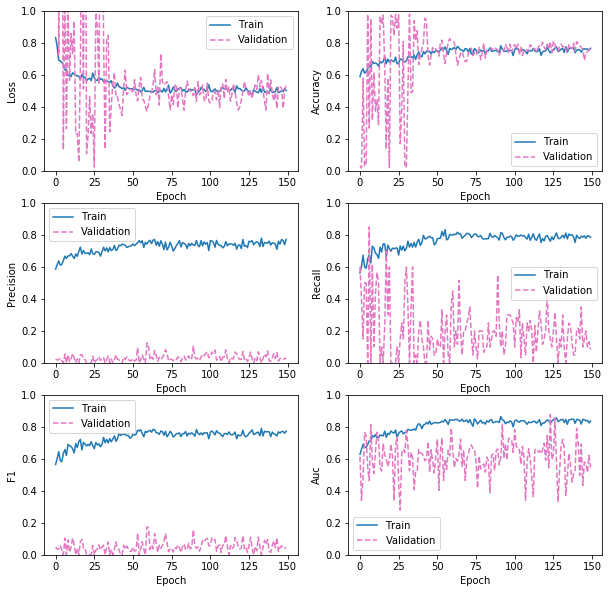

In [67]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [19]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 12s 123ms/step


In [22]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 0.599 :   0.506
Accuracy : 0.567 :   0.761
Precision : 0.566 :   0.033
Recall : 0.476 :   0.167
F1 : 0.510 :   0.053
AUC : 0.600 :   0.577


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [23]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(6181.880176544189, 140.27913308143616)

In [24]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [25]:
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_tr_81unfreze.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_vl_81unfreze.npy', pred_vl)

### ROC Curve

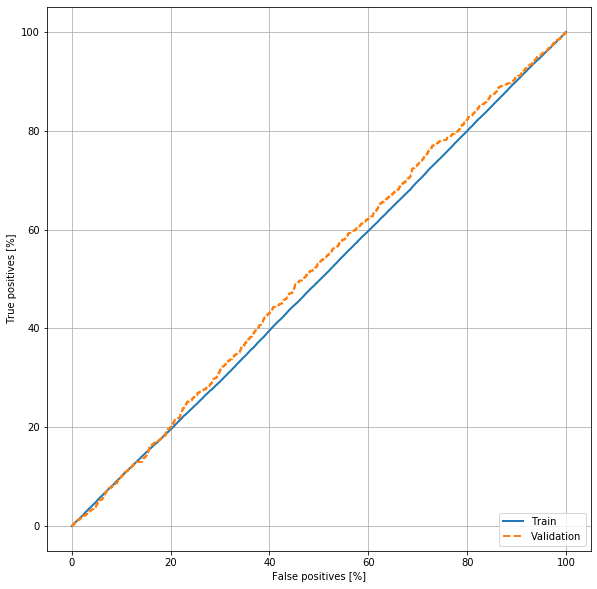

In [26]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 58637 
FP: 40818 
FN: 58986 
TP: 40469
Healthy Patients - correctly identified (True Negatives):  58637 0.5895832285958473
Healthy Patients - predicted to have glaucoma (False Positives):  40818 0.4104167714041526
Glaucoma Patients - predicted healthy (False Negatives):  58986 0.5930923533256246
Glaucoma Patients - correctly identified (True Positives):  40469 0.40690764667437535

Total Glaucoma patients:  99455 1.0
Total Healthy patients:  99455 1.0


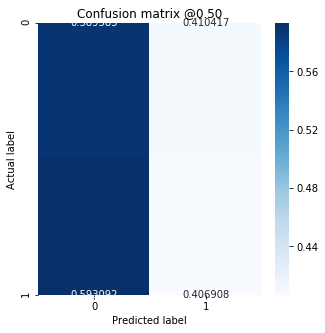

In [27]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 25730 
FP: 7404 
FN: 620 
TP: 189
Healthy Patients - correctly identified (True Negatives):  25730 0.7765437315144564
Healthy Patients - predicted to have glaucoma (False Positives):  7404 0.22345626848554356
Glaucoma Patients - predicted healthy (False Negatives):  620 0.7663782447466008
Glaucoma Patients - correctly identified (True Positives):  189 0.23362175525339926

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


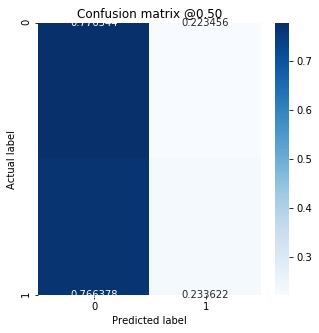

In [28]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

In [31]:
get_notebook_name()

<IPython.core.display.Javascript object>

'CNN Fundus- RUN1-Copy3.ipynb'

### MLFlow 

In [32]:
# # history = imb_history
# tag_value = "single train RUN1-Copy3 with samplewise_center = True"
# myname = get_notebook_name()
# exp_name = myname +"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [33]:
# client = MlflowClient()
# run = client.create_run('25')
# client.set_tag(run.info.run_id, "tag_key", tag_value)